In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
IMAGE = "images/a6595ad23b83401da7c1bc8a24dbfc40.jpg"
MODEL_PATH = "../models/best_model.pth"
NUM_CLASSES = 3
CONFIDENCE_THRESHOLD = 0.5
CLASS_NAMES = {1: 'bottle', 2: 'cap'}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

checkpoint = torch.load(MODEL_PATH, map_location=device)

if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)
model.to(device)
model.eval()

frame = cv2.imread(IMAGE)

image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
transform = T.Compose([T.ToTensor()])
image_tensor = transform(image_rgb)

with torch.no_grad():
    predictions = model([image_tensor.to(device)])

# Extract predictions
pred = predictions[0]
boxes = pred['boxes'].cpu().numpy()
scores = pred['scores'].cpu().numpy()
labels = pred['labels'].cpu().numpy()

# Filter by confidence
mask = scores >= CONFIDENCE_THRESHOLD
boxes = boxes[mask]
scores = scores[mask]
labels = labels[mask]

D:\anaconda3\envs\vision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\envs\vision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_ARUCO_ORIGINAL)
parameters = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(dictionary, parameters)

CORNER_MARKERS = [11, 10, 15, 16]
plane_points = np.array([
    [0, 0],
    [154, 0],
    [154, 154],
    [0, 154]
], dtype=np.float32)

In [4]:
def detect_all_markers(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejected = detector.detectMarkers(gray)
    return corners, ids

In [5]:
def get_plane_markers(corners, ids):
    if ids is None:
        return None

    ids = ids.flatten()
    pts = {}

    for corner, id_ in zip(corners, ids):
        if id_ in CORNER_MARKERS:
            c = corner[0]
            center = np.mean(c, axis=0)
            pts[id_] = center

    if len(pts) != 4:
        return None

    ordered = np.array([pts[i] for i in CORNER_MARKERS], dtype=np.float32)
    return ordered

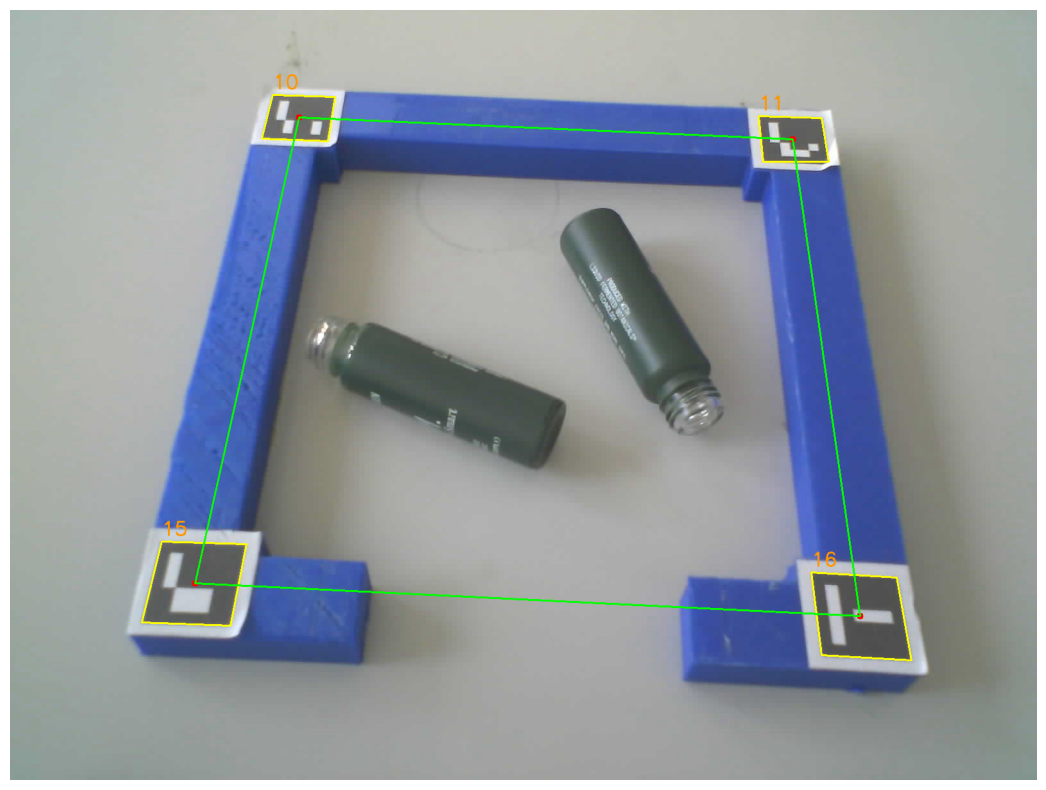

In [6]:
corners, ids = detect_all_markers(frame)

if ids is not None:
    for corner, id_ in zip(corners, ids.flatten()):
        pts = corner[0].astype(int)

        cv2.polylines(frame, [pts], True, (0, 255, 255), 2)

        center = tuple(np.mean(pts, axis=0).astype(int))
        cv2.circle(frame, center, 5, (0, 0, 255), -1)

        cv2.putText(frame, f"{id_}", (pts[0][0], pts[0][1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 150, 255), 2)

plane_markers = get_plane_markers(corners, ids)
if plane_markers is not None:
    H, _ = cv2.findHomography(plane_markers, plane_points)

    pts = np.float32(plane_points).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, np.linalg.inv(H))
    dst = np.int32(dst)

    cv2.polylines(frame, [dst], True, (0, 255, 0), 2)

plt.figure(figsize=(40,10))
plt.axis("off")
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

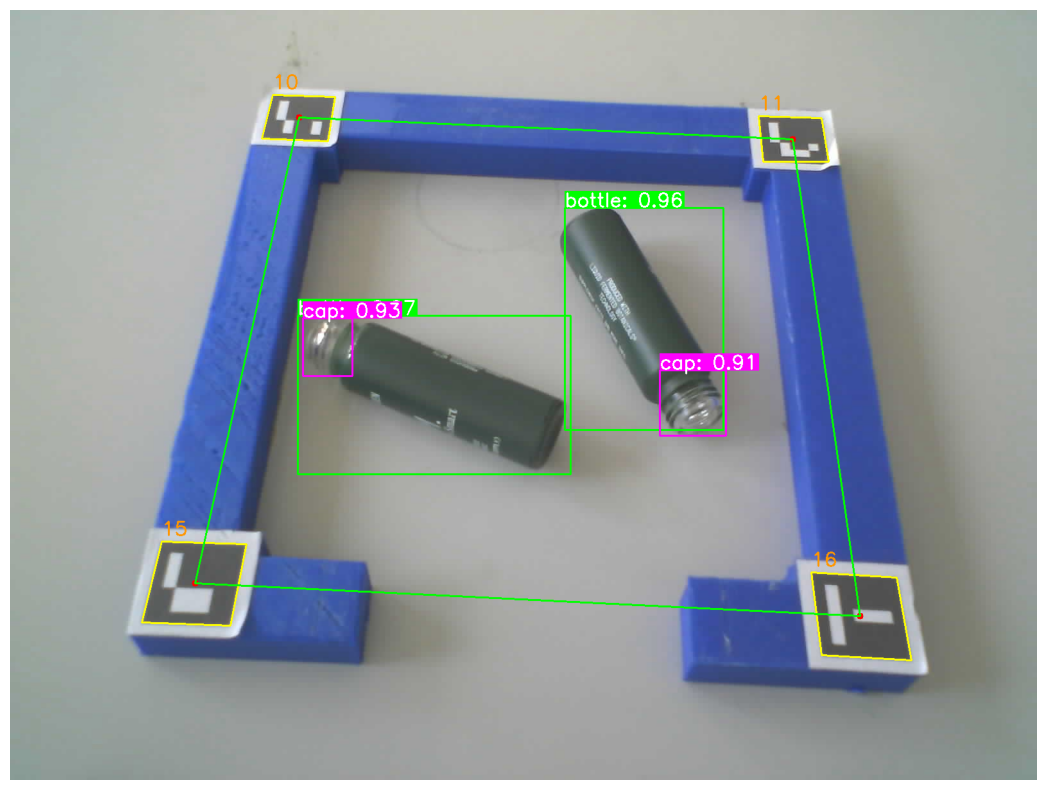

In [ ]:
image_copy = frame.copy()

# Different colors for different classes
class_colors = {
    1: (0, 255, 0),      # Green for bottle
    2: (255, 0, 255),    # Magenta for cap
}

for box, score, label in zip(boxes, scores, labels):
    x1, y1, x2, y2 = box.astype(int)

    # Get color for class
    color = class_colors.get(label, (0, 255, 0))

    # Draw box
    cv2.rectangle(image_copy, (x1, y1), (x2, y2), color, 2)

    # Draw label and score
    class_name = CLASS_NAMES.get(label, f'Class {label}')
    text = f'{class_name}: {score:.2f}'

    # Background for text
    (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(image_copy, (x1, y1 - text_height - 4), (x1 + text_width, y1), color, -1)

    # Text
    cv2.putText(image_copy, text, (x1, y1 - 2), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)


plt.figure(figsize=(40,10))
plt.axis("off")
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))

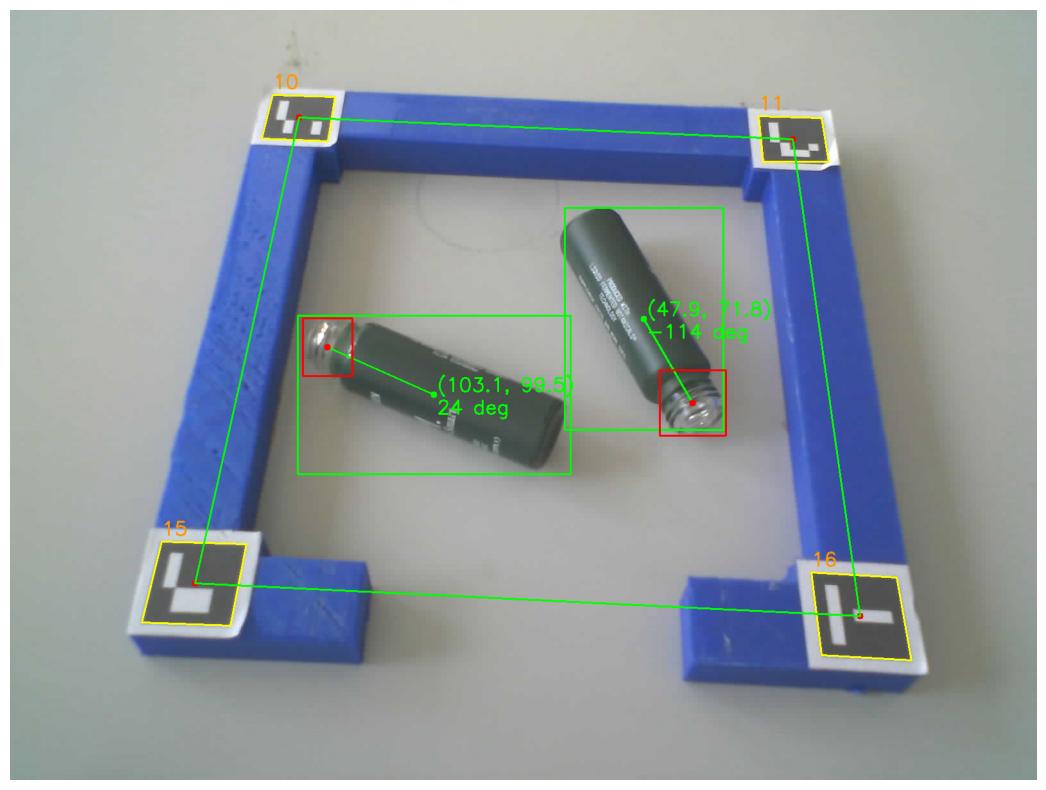

In [ ]:
f_copy = frame.copy()

bottles = []
caps = []

img_h, img_w, _ = frame.shape

# Split detected objects by class
for box, score, label in zip(boxes, scores, labels):
    x1, y1, x2, y2 = box.astype(int)

    cls_name = CLASS_NAMES.get(label, f'Class {label}')

    x, y = (x1 + x2) / 2, (y1 + y2) / 2
    pts = np.array([[x1,y1],[x1,y2],[x2,y2],[x2,y1]]).astype(np.int32)

    mask = np.zeros((img_h, img_w), dtype=np.uint8)
    cv2.fillPoly(mask, [pts], 255)

    pix = np.array([[x, y, 1]], dtype=np.float32).T
    pt = H @ pix
    pt /= pt[2]
    coords = (pt[0][0], pt[1][0])

    obj = {
        "center": (int(x), int(y)),
        "pts": pts,
        "mask": mask,
        "conf": score,
        "coords": coords
    }

    if cls_name == 'bottle':
        bottles.append(obj)
    elif cls_name == 'cap':
        caps.append(obj)

# Visualise
for i in range(len(bottles)):
    b = bottles[i]
    b['cap'] = None
    best_coverage = 0.5
    for c in caps:
        count = cv2.countNonZero(cv2.bitwise_and(b['mask'], c['mask']))
        coverage = count / cv2.countNonZero(c['mask'])
        if coverage > best_coverage:
            b['cap'] = c['center']
            b['cap_coords'] = c['coords']

    b['orientation'] = 0
    if b['cap'] is not None:
        bottle_center = np.array(b['coords'])
        cap_center = np.array(b['cap_coords'])

        vec = cap_center - bottle_center

        angle = np.degrees(np.arctan2(vec[0], vec[1])) + 90

        orientation = angle % 360 - 180
        b['orientation'] = orientation

for b in bottles:
    if b['cap'] is None:
        continue

    cv2.drawContours(frame, [b["pts"]], -1, (0, 255, 0), 2)
    cv2.line(frame, b["center"], b["cap"], color=(0, 255, 0), thickness=2)
    cv2.circle(frame, b["center"], 5, (0, 255, 0), -1)
    cv2.putText(frame, f"({b['coords'][0]:.1f}, {b['coords'][1]:.1f})",
                (b["center"][0] + 5, b["center"][1] - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"{int(b['orientation'])} deg",
                (b["center"][0] + 5, b["center"][1] + 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

for c in caps:
    cv2.drawContours(frame, [c["pts"]], -1, (0, 0, 255), 2)
    cv2.circle(frame, c["center"], 5, (0, 0, 255), -1)

plt.figure(figsize=(40,10))
plt.axis("off")
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

frame = f_copy